In [93]:
%run ../common_utils.py

In [52]:
import lightgbm as lgbm
from sklearn.ensemble import GradientBoostingRegressor
import xgboost

# Global Parameters

In [5]:
random_state = 1
number_of_splits = 5

# Load All Data

In [39]:
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = []

# Load data
train, test, metaData = load_all_data()
# Clean data
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features, log_targets=False, log_area=True, fillNan=True)
# Add new features
train_labels, test_labels, added_features = feature_engineering(train_labels, test_labels, float_numerical_features, int_numerical_features, cat_features)
# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")
# One-hot encoding
train_labels_one_hot, test_labels_one_hot = one_hot_encoder(train_labels, test_labels, ["condition", "district", "material", "parking", "heating", "seller"], drop_old=True)
# Drop some features
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)
train_labels_one_hot.drop(droptable, inplace=True, axis=1)
test_labels_one_hot.drop(droptable, inplace=True, axis=1)

minMax


# Model 1 LGBM

In [8]:
params= {
 'num_iterations': 10000,
 'n_estimators': 152,
 'learning_rate': 0.05,
 'num_leaves': 40,
 'max_depth': 10,
 'min_data_in_leaf': 20,
 'bagging_fraction': 0.9,
 'bagging_freq': 5,
 'feature_fraction': 0.8,
}
model1 = lgbm.LGBMRegressor(
    **params, 
    random_state=random_state,
    early_stopping_round=100,
    silent=True,
    metric='regression',
    num_threads=4)

In [22]:
%%capture --no-display
oof_train_lgbm, oof_test_lgbm, scores_lgbm = get_oof_lgbm(model1, train_labels_one_hot, np.log(train_targets), test_labels_one_hot, NFOLDS=number_of_splits, eval_metric='neg_root_mean_squared_error')

# Model 2 Gradient Boost

In [25]:
optimal_n_estimators = 300
optimal_max_depth = 13
optimal_min_samples_split = 1000
optimal_min_samples_leaf = 40
optimal_max_features = 40
optimal_subsample = 0.95
original_learning_rate = 0.1

model2 = GradientBoostingRegressor(
            n_estimators = optimal_n_estimators*10,
            max_depth = optimal_max_depth,
            min_samples_split = optimal_min_samples_split,
            min_samples_leaf = optimal_min_samples_leaf,
            max_features = optimal_max_features,
            subsample = optimal_subsample,
            learning_rate = original_learning_rate / 10,
            loss = 'squared_error',
            criterion = 'squared_error',
            verbose = 0,
            warm_start = False,
            random_state = random_state,
        )

In [31]:
oof_train_gb, oof_test_gb, scores_gb = get_oof_gradientboost(model2, train_labels_one_hot, np.log(train_targets), test_labels_one_hot, NFOLDS=number_of_splits)

# Model 3 XGBoost

In [54]:
model3 = xgboost.XGBRegressor(
    max_depth=5, 
    min_child_weight=12, 
    gamma=0.15, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    reg_alpha=1.1, 
    reg_lambda=0.3, 
    learning_rate=0.01, 
    n_estimators=10000
)

In [55]:
oof_train_xgb, oof_test_xgb, scores_xgb = get_oof_gradientboost(model3, train_labels_one_hot, np.log(train_targets), test_labels_one_hot, NFOLDS=number_of_splits)

# Model 4 RF

In [ ]:
model4 = RandomForestRegressor(
        n_estimators=2000,
        max_depth=400,
        min_samples_split=2,
        min_samples_leaf= 2,
        min_weight_fraction_leaf=0.00008,
        max_features='auto',
        max_leaf_nodes=None,
        min_impurity_decrease=1100,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
        warm_start=True,
        ccp_alpha=20000,
        max_samples=None
    )
features = ["area_total", "latitude", "longitude", "floor", "district", "stories", 'condition'] 

In [51]:
oof_train_rf, oof_test_rf, scores_rf = get_oof_rf(train_labels[features], train_targets, test_labels[features], NFOLDS=number_of_splits)

# King Model

In [128]:
params_king= {
 'num_iterations': 10000,
 'n_estimators': 152*5,
 'learning_rate': 0.05/5,
 'num_leaves': 40,
 'max_depth': 10,
 'min_data_in_leaf': 20,
 'bagging_fraction': 0.9,
 'bagging_freq': 5,
 'feature_fraction': 0.8,
}
model_king = lgbm.LGBMRegressor(
    **params_king, 
    random_state=random_state,
    early_stopping_round=100,
    silent=True,
    metric='regression',
    num_threads=4)
model_king_no_cv = lgbm.LGBMRegressor(
    **params, 
    random_state=random_state,
    silent=True,
    metric='regression',
    num_threads=4)

In [129]:
stacking_labels = train_labels_one_hot.copy()
stacking_labels_log = train_labels_one_hot.copy()

stacking_test = test_labels_one_hot.copy()
stacking_test_log = test_labels_one_hot.copy()

In [130]:
stacking_labels['lgbm_prediction'] = np.exp(oof_train_lgbm)
stacking_labels['gb_prediction'] = np.exp(oof_train_gb)
stacking_labels['rf_prediction'] = oof_train_rf
stacking_labels['xgb_prediction'] = np.exp(oof_train_xgb)
stacking_labels_log['lgbm_prediction'] = oof_train_lgbm
stacking_labels_log['gb_prediction'] = oof_train_gb
stacking_labels_log['rf_prediction'] = np.log(oof_train_rf)
stacking_labels_log['xgb_prediction'] = oof_train_xgb

stacking_test['lgbm_prediction'] = np.exp(oof_test_lgbm)
stacking_test['gb_prediction'] = np.exp(oof_test_gb)
stacking_test['rf_prediction'] = oof_test_rf
stacking_test['xgb_prediction'] = np.exp(oof_test_xgb)
stacking_test_log['lgbm_prediction'] = oof_test_lgbm
stacking_test_log['gb_prediction'] = oof_test_gb
stacking_test_log['rf_prediction'] = np.log(oof_test_rf)
stacking_test_log['xgb_prediction'] = oof_test_xgb

oof_predictions = ['lgbm_prediction','gb_prediction','rf_prediction','xgb_prediction']

In [131]:
# all logged

In [132]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model_king,
    X_train=stacking_labels_log, 
    y_train=np.log(train_targets),
    eval_metric = 'neg_root_mean_squared_error'
    )

In [133]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.21284427374147327, 0.1856117308622038, 0.20313675714034768, 0.18931680233667963, 0.23967636808005213]
average score:  0.20611718643215132
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.01, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=760,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     1


In [141]:
len(list(lgbm_importances))

72

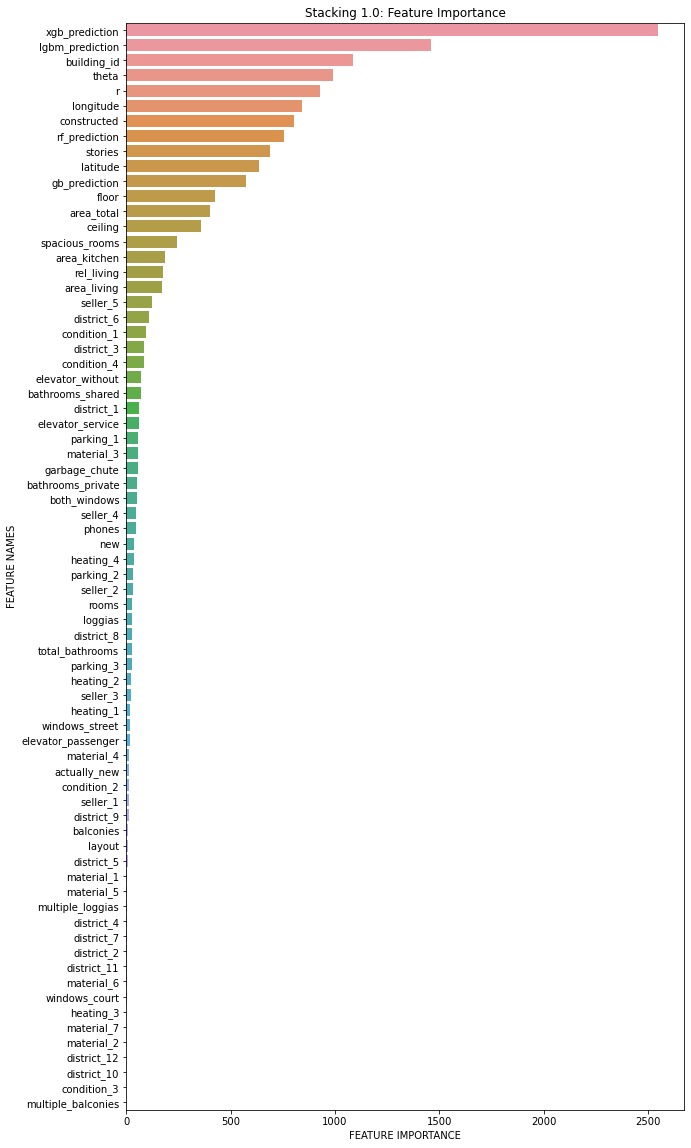

In [143]:
lgbm_importances = model_king.feature_importances_
plot_feature_importance(lgbm_importances, list(stacking_labels_log.columns), 'Stacking 1.0: ')

In [145]:
model_king_no_cv.fit(stacking_labels_log,np.log(train_targets))
predict_and_store(model_king_no_cv, stacking_test_log, test, path=".\submissions\stacking1.0.csv", exponential=True)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [ ]:
# all exponential

In [146]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model_king,
    X_train=stacking_labels, 
    y_train=np.log(train_targets))

In [147]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.21305737652414106, 0.18541994040920334, 0.20265764391813348, 0.18939044660787824, 0.2395299053358475]
average score:  0.20601106255904073
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.01, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=760,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     1


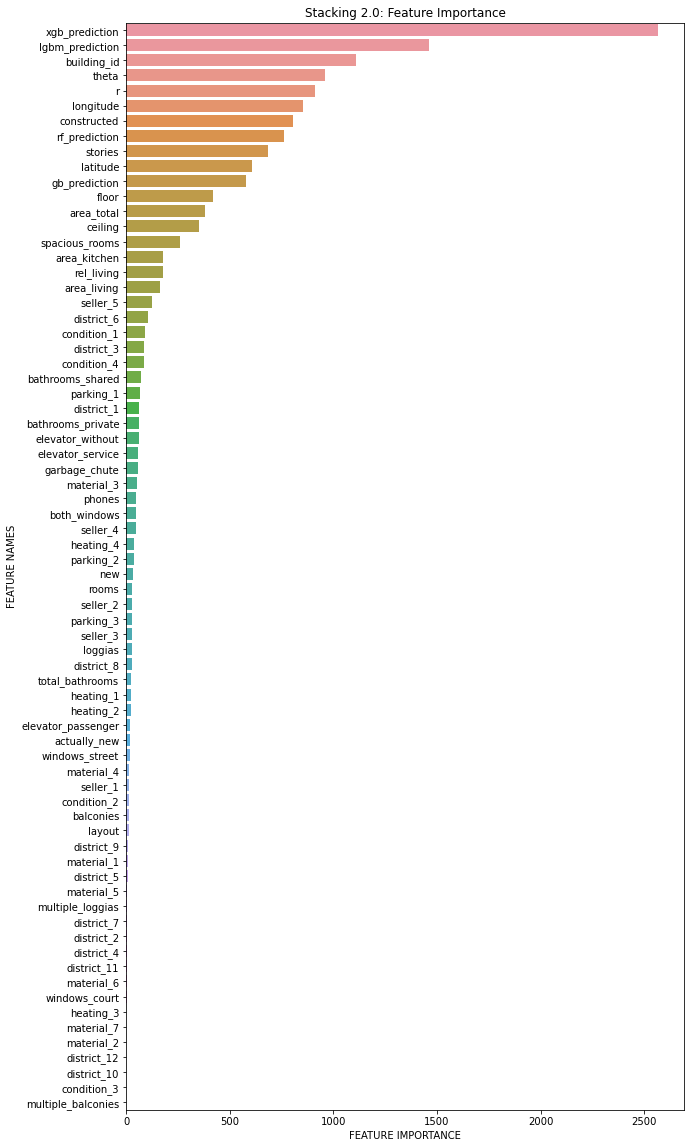

In [148]:
lgbm_importances = model_king.feature_importances_
plot_feature_importance(lgbm_importances, list(stacking_labels_log.columns), 'Stacking 2.0: ')

In [149]:
model_king_no_cv.fit(stacking_labels_log,np.log(train_targets))
predict_and_store(model_king_no_cv, stacking_test_log, test, path=".\submissions\stacking2.0.csv", exponential=True)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [150]:
# on only oof data (logged)

In [151]:
oof_predictions_building_id = oof_predictions + ['building_id']

In [152]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model_king,
    X_train=stacking_labels_log[oof_predictions_building_id], 
    y_train=np.log(train_targets))

In [153]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.20315433158524007, 0.1824478000016825, 0.1953761916578351, 0.19010815780015014, 0.23232859404517295]
average score:  0.20068301501801616
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.01, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=760,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     1


In [164]:
len(oof_predictions)

4

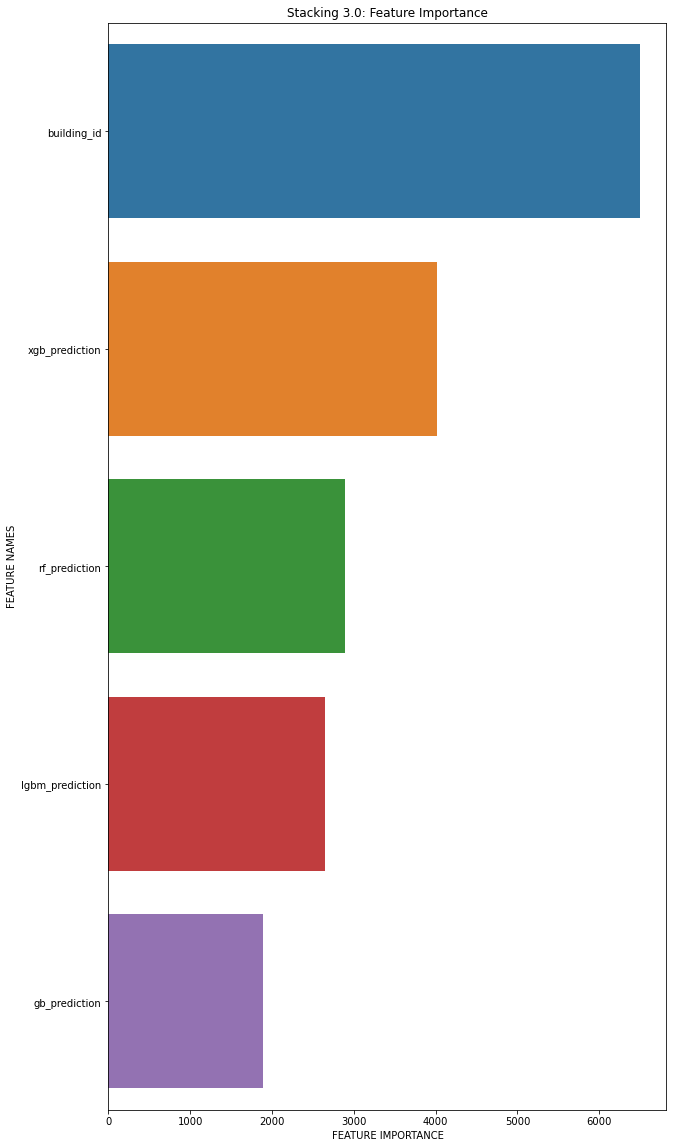

In [165]:
lgbm_importances = model_king.feature_importances_
plot_feature_importance(lgbm_importances, list(oof_predictions_building_id), 'Stacking 3.0: ')

In [169]:
stacking_labels_log.drop(['building_id'],axis=1,inplace=True)
stacking_test_log.drop(['building_id'],axis=1,inplace=True)

In [170]:
model_king_no_cv.fit(stacking_labels_log,np.log(train_targets))
predict_and_store(model_king_no_cv, stacking_test_log, test, path=".\submissions\stacking3.0.csv", exponential=True)

In [171]:
# on only oof data (exponential)

In [ ]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model_king,
    X_train=stacking_labels[oof_predictions_building_id], 
    y_train=np.log(train_targets))

In [ ]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

In [ ]:
lgbm_importances = model_king.feature_importances_
plot_feature_importance(lgbm_importances, list(stacking_labels_log.columns), 'Stacking 4.0: ')

In [172]:
stacking_labels.drop(['building_id'],axis=1,inplace=True)
stacking_test.drop(['building_id'],axis=1,inplace=True)

In [173]:
model_king_no_cv.fit(stacking_labels_log,np.log(train_targets))
predict_and_store(model_king_no_cv, stacking_test_log, test, path=".\submissions\stacking4.0.csv", exponential=True)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
